In [1]:
import sys, os
import pandas as pd
from sklearn.model_selection import train_test_split

from lcc.db_tier.connectors import FileManager, OgleII, OgleII
from lcc.data_manager.package_reader import PackageReader
from lcc.stars_processing.systematic_search.stars_searcher import StarsSearcher, StarsSearcherRedis
from lcc.stars_processing.tools.visualization import plotProbabSpace
from lcc.stars_processing.tools.params_estim import ParamsEstimator
from lcc.utils.output_process_modules import saveIntoFile, loadFromFile
from lcc.utils.stars import saveStars, plotStarsPicture
from lcc.utils.helpers import get_combinations
from lcc.api.input_parse import parse_tun_query

%matplotlib inline

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (24.0, 8.0)

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

# Define the task
In this example our task is to make a model which would distinguish quasars from Be stars which light curves are very simmilar. 

In [2]:
# We will be using Abbe value and variogram slope to describe each light curve
# and the "brain" of the filter will be Gradient Boosting
descr_name1 = "AbbeValueDescr"
descr_name2 = "VariogramSlopeDescr"
decid_name = "GradBoostDec"


# Parameters to tune and their ranges
tun_param1 = "bins"
bin_from = 10
bin_to = 150
bin_step = 50

tun_param2 = "days_per_bin"
dpb_from = 30
dpb_to = 110
dpb_step = 10


# Load example stars which are included in the package
obt_method = "FileManager"
quasars_path = PackageReader.getSamplePath("qso")
be_stars_path = PackageReader.getSamplePath("be_stars")

# Show available descriptors and classifiers
Note: You can arbitrary number of descriptors and classifiers

In [3]:
all_descriptors = PackageReader().getClassesDict("descriptors")
all_deciders = PackageReader().getClassesDict("deciders")

print("Descriptors: {}\n".format(", ".join(all_descriptors.keys())))
print("Deciders: {}".format(", ".join(all_deciders.keys())))

Using TensorFlow backend.


Descriptors: AbbeValueDescr, VariogramSlopeDescr, CurvesShapeDescr, HistShapeDescr, VariogramShapeDescr, PropertyDescr, ColorIndexDescr, SkewnessDescr, KurtosisDescr, CurveDensityDescr, PositionDescriptor, CurveDescr

Deciders: CustomDecider, AdaBoostDec, ExtraTreesDec, GaussianNBDec, GradBoostDec, LDADec, QDADec, RandomForestDec, SVCDec, TreeDec, NeuronDecider


Note: `all_descriptors` and `all_deciders` are dictionaries of descriptors and deciders classes which can be directly used. For example:
```
my_descriptor = all_descriptors["AbbeValueDescr"](bins=100)
```

is same as:
```
from lcc.stars_processing.descriptors import AbbeValueDescr

my_descriptor = AbbeValueDescr(bins=100)
```

# Get descriptors and a classifier

In [4]:
abbe_descr = all_descriptors.get(descr_name1)
vario_slope_descr = all_descriptors.get(descr_name2)
decider = all_deciders.get(decid_name)

# Make list of all parameters combination

In [5]:
combinations = get_combinations([":".join([descr_name1, tun_param1]), ":".join([descr_name2, tun_param2])],
                                 range(bin_from, bin_to, bin_step), range(dpb_from, dpb_to, dpb_step))
tun_params = parse_tun_query(combinations)

In [6]:
tun_params[:3]

[{'AbbeValueDescr': {'bins': 10}, 'VariogramSlopeDescr': {'days_per_bin': 30}},
 {'AbbeValueDescr': {'bins': 10}, 'VariogramSlopeDescr': {'days_per_bin': 40}},
 {'AbbeValueDescr': {'bins': 10}, 'VariogramSlopeDescr': {'days_per_bin': 50}}]

# Load stars

In [7]:
quasars = FileManager({"path": quasars_path}).getStars()
be_stars = FileManager({"path": be_stars_path}).getStars()

Loading FITS files:: 100%|██████████| 221/221 [00:18<00:00, 12.26it/s]


### Clean sample
Keep just stars with light curves which have certain size

In [8]:
quasars = [st for st in quasars if st.lightCurve and len(st.lightCurve.mag) >= bin_to]
be_stars = [st for st in be_stars if st.lightCurve and len(st.lightCurve.mag) >= bin_to]

### Train - test split

In [9]:
quasars_train, quasars_test = train_test_split(quasars, train_size=0.8)
be_stars_train, be_stars_test = train_test_split(be_stars, train_size=0.8)

### Show random quasars

In [10]:
import random

random.shuffle(quasars)
for star in quasars[:3]:
    print("*"*20)
    print(star)
    print()

********************
MACHO identifier:	name: 64.8092.454	


********************
xray identifier:	name: 	
mqs identifier:	name: MQS J053212.24-693130.9	
radio identifier:	name: 	
OgleII identifier:	name: LMC_SC2_407170	db_ident: {'field': 'LMC_SC2', 'starid': 407170}	
	Coordinate: 05h32m12.3684s -69d31m30.792s

********************
xray identifier:	name: 3XMM J050713.6-685952	
mqs identifier:	name: MQS J050713.52-685952.5	
radio identifier:	name: 	
OgleII identifier:	name: LMC_SC13_220502	db_ident: {'field': 'LMC_SC13', 'starid': 220502}	
	Coordinate: 05h07m13.6308s -68d59m52.512s



### Plot distribution of magnitudes, variogram and light curve of random quasars

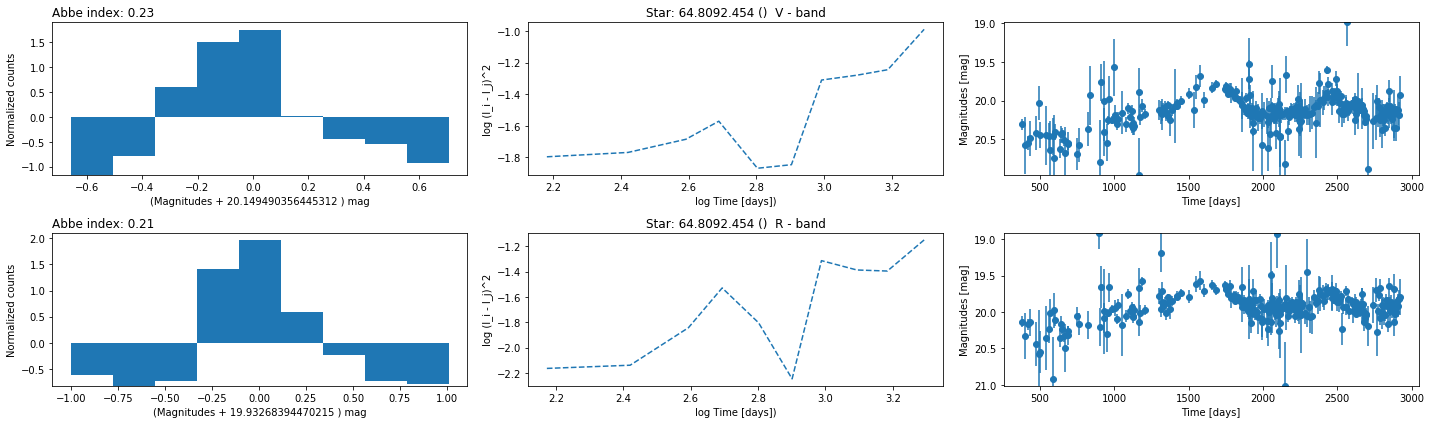

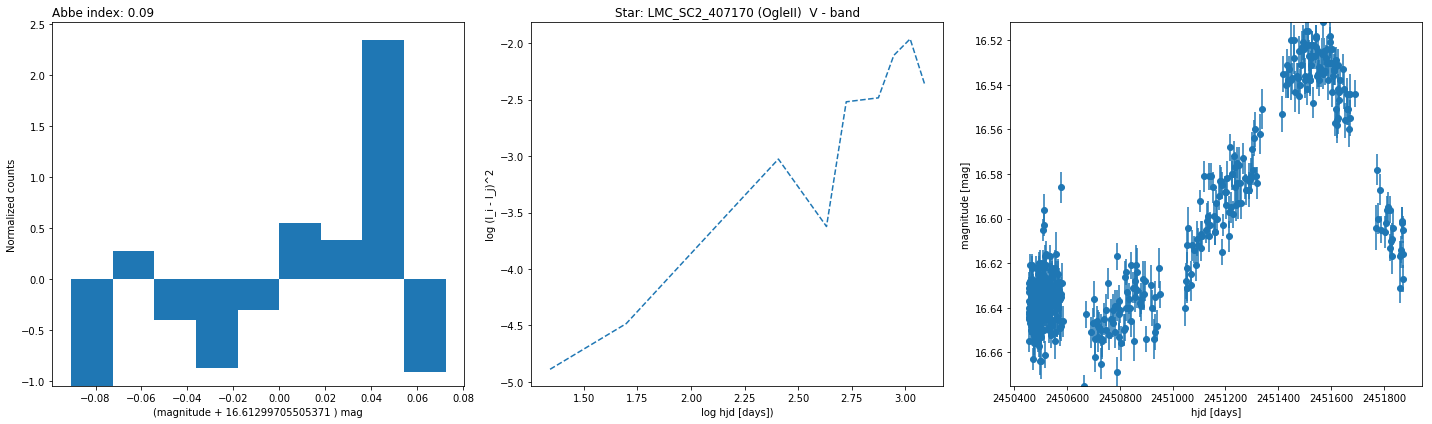

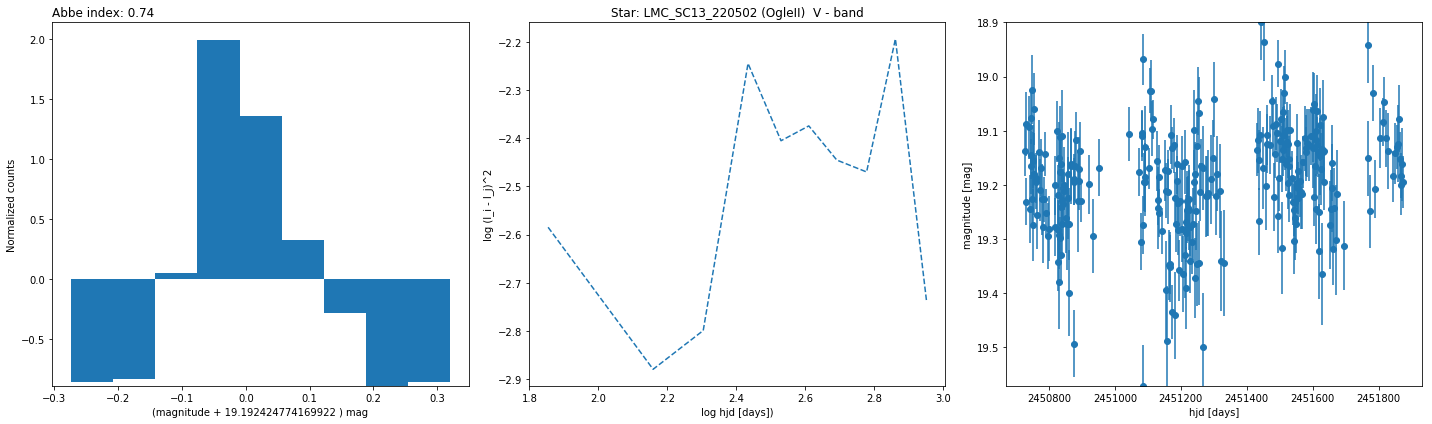

In [11]:
plotStarsPicture(quasars[:3])

In [12]:
# Light curves description
quasars[0].lightCurve.meta

{'color': 'V',
 'origin': '',
 'xlabel': 'Time',
 'xlabel_unit': 'days',
 'ylabel': 'Magnitudes',
 'ylabel_unit': 'mag'}

# Find optimal parameters

In [13]:
# Estimate all combinations and get the best one
es = ParamsEstimator(searched=quasars_train,
                     others=be_stars_train,
                     descriptors=[abbe_descr, vario_slope_descr],
                     deciders=[decider],
                     tuned_params=tun_params)

star_filter, best_stats, best_params = es.fit()

All 24 combinations have been evaluated/Users/martinvo/workspace/private2/LightCurvesClassifier/lcc/stars_processing/tools/params_estim.py:200: UserWarning: 
Error during saving outputs...:
	module 'types' has no attribute 'InstanceType'
  warnings.warn("\nError during saving outputs...:\n\t%s" % e)


In [14]:
print("Optimal parameters: {}".format(es.tuned_params[0]))
pd.DataFrame(es.stats)

Optimal parameters: {'AbbeValueDescr': {'bins': 10}, 'VariogramSlopeDescr': {'days_per_bin': 30}}


""


### Show features for some quasars

In [15]:
star_filter.getSpaceCoordinates(quasars[:5])

,Abbe value,Light curve's variogram slope
64.8092.454,0.234116,0.678967
LMC_SC2_407170,0.018131,1.625663
LMC_SC13_220502,0.371647,0.258574
SMC_SC3_130350,0.159039,1.620601
LMC_SC4_21565,0.682249,0.197449


# Evaluate model
Now we can use tuned filter to predict whether given stars are quasars or not. Note that we're evaluating on the test
sample.

In [16]:
prediction_quasars = star_filter.evaluateStars(quasars_test)
prediction_be_stars = star_filter.evaluateStars(be_stars_test)

In [17]:
prediction_quasars.head()

2.5873.82          0.12
LMC_SC13_214352    0.98
SMC_SC9_87380      0.99
69.12549.21        0.02
SMC_SC1_45081      0.21
dtype: float64

### Probability plot
Purple stars are quasars, black are Be stars. Color on the background represents probability of an object
to be quasar (scaled by colorbar on the right)

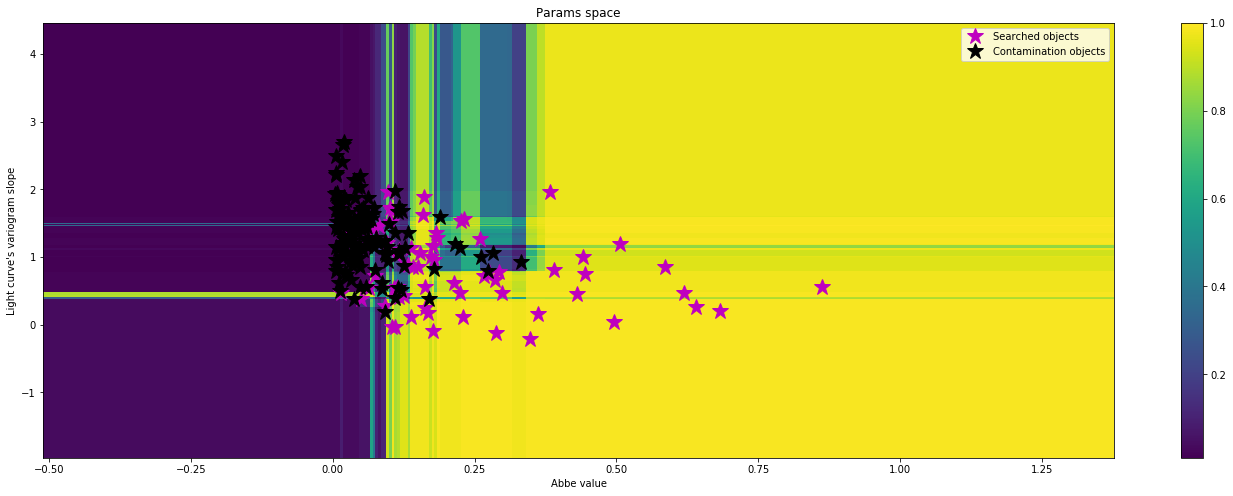

In [18]:
plotProbabSpace(star_filter)

# Find a quasar candidates in OGLEII
NOTE: Sometimes OgleII doesn't work because their database, so if the query takes too long, maybe it's that case 

In [19]:
# This should return a star from OGLEII
ogle_star = OgleII({"starid": 1, "field_num": 2, "target": "lmc"}).getStars()

In [20]:
# Query for OgleII
db_name = "OgleII"
starid_from = 1
starid_to = 10
field_num_from = 1
field_num_to = 2
target = "lmc"

In [21]:
# Prepare queries and run sequential systematic search by using filter
queries = get_combinations(["starid", "field_num", "target"],
                           range(starid_from, starid_to),
                           range(field_num_from, field_num_to),
                           [target])

searcher = StarsSearcher([star_filter],
                         db_connector=db_name,
                         stat_file_path="/tmp/lcc_status.csv",
                        save_coords=True)
searcher.queryStars(queries)

passed_stars = searcher.getPassedStars()

/Users/martinvo/workspace/private2/LightCurvesClassifier/lcc/stars_processing/systematic_search/stars_searcher.py:181: UserWarning: Removing existing status file /tmp/lcc_status.csv
  warnings.warn("Removing existing status file {}".format(stat_file_path))
Loading FITS files:: 100%|██████████| 9/9 [00:00<00:00, 13.70it/s]


In [22]:
searcher.getStatus()

,Abbe value,GradBoostDec,Light curve's variogram slope,found,lc,passed,passed_GradBoostDec
star_name,,,,,,,
LMC_SC1_1,0.271766,0.743301,0.385947,True,True,True,True
LMC_SC1_2,0.401306,0.993926,-0.128386,True,True,True,True
LMC_SC1_3,0.507551,0.993926,-0.178724,True,True,True,True
LMC_SC1_4,0.302269,0.953597,0.637023,True,True,True,True
LMC_SC1_5,0.135854,0.976475,-0.153439,True,True,True,True
LMC_SC1_6,0.552128,0.993926,0.153158,True,True,True,True
LMC_SC1_7,0.050737,0.061906,-0.470107,True,True,False,False
LMC_SC1_8,0.140007,0.957434,0.560850,True,True,True,True
LMC_SC1_9,0.068299,0.588846,-0.189427,True,True,True,True


In [23]:
saveStars(quasars[:5], "/tmp")

['64.8092.454',
 'LMC_SC2_407170',
 'LMC_SC13_220502',
 'SMC_SC3_130350',
 'LMC_SC4_21565']

## Redis searcher

In [24]:
redis_searcher = StarsSearcherRedis([star_filter], db_connector=db_name, save_coords=True)
redis_searcher.queryStars(queries)

passed_stars = redis_searcher.getPassedStars()

Remaining jobs: 5
Remaining jobs: 5
Remaining jobs: 5
Remaining jobs: 1
Remaining jobs: 1
Remaining jobs: 1


Loading FITS files::  11%|█         | 1/9 [00:00<00:00,  8.75it/s]

Remaining jobs: 0


Loading FITS files:: 100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


In [26]:
# redis_searcher.getStatus()